In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{pifont} ')

import scipy.integrate as si
import scipy.interpolate as sp
import scipy.optimize as so
import time

Abs=np.abs
Log=np.log
Log10=np.log10
Pi=np.pi
ArcTanh=np.arctanh
Sqrt=np.sqrt
Exp=np.exp
Cos=np.cos
Sin=np.sin
HeavisideTheta=lambda x: np.heaviside(x,0)
def Plot(fun,xminmax,n=100):
    xlist=np.linspace(xminmax[0],xminmax[1],n)
    ylist=[fun(x) for x in xlist]
    plt.plot(xlist,ylist)
def ListPlot(data):
    xlist=data[:,0]
    ylist=data[:,1]
    plt.plot(xlist,ylist)
    
def root_concave(fun,bracket,rtol=1e-5):
    def newfun(x):
#         print ("x =", x)
        if x > bracket[1]:
#             print ("x too large:", x)
            return fun(bracket[1])+(x-bracket[1])
        if x < bracket[0]:
#             print ("x too small:", x)
            return fun(bracket[0])+(bracket[0]-x)
            
        y=fun(x)
        if y>=0:
            return y
        else:
            raise Exception('f<0 already found', x)
    try:      
        mini=so.minimize_scalar(newfun,bracket=bracket)#,options={"maxiter":10})
        if mini.fun>0: return None
        xmin=mini.x
    except Exception as inst:
#         print (inst.args)
        xmin=inst.args[1]
    sol1=so.root_scalar(fun,bracket=[bracket[0],xmin],rtol=rtol)
    sol2=so.root_scalar(fun,bracket=[xmin,bracket[1]],rtol=rtol)

    return sol1.root,sol2.root

# V3

In [2]:
GeV=1
MeV=1e-3*GeV
eV=1e-9*GeV
meter=5.06842372022301e6 /eV
me=0.511 * MeV
per_GeV_per_m2=GeV**(-1) *meter**(-2)

In [3]:
mAr=39.948*931.494102 *MeV
ton=1e3*1e3*5.610e32 *eV
Ne=1*ton/mAr * 18 #each Ar atom has 18 electrons
POT=1.1e21
Ne_POT=Ne * POT

In [4]:
def Tmax(En):#En=Eν
    return (2* En**2)/(me + 2 * En)
    #see also LXe/code/chi2_setup.nb
    
def Tmin(En):
    return 0.5*GeV
def Tcut(En,T):
    if Tmin(En)<T<Tmax(En):
        return 1
    else:
        return 0
def Tcut_debug(En,T,T1T2=[]):
    if Tmin(En)<=T<=Tmax(En):
        return 1
    else:
        print (En, T,(Tmin(En),T,Tmax(En)),T1T2)
        raise ValueError
        
##################################################################
# cross section generated from cross_section_to_python.nb

σ_νμ_SM=\
"4.422808381641405e-14*(0.0729 + (0.0000317331*T)/Enu**2 + 0.0529*(1 - T/Enu)**2)"

σ_̄νμ_SM=\
"4.422808381641405e-14*(0.0529 + (0.0000317331*T)/Enu**2 + 0.0729*(1 - T/Enu)**2)"

σ_νe_SM="4.422808381641405e-14*(0.5328999999999999 - \
(0.00008579689999999998*T)/Enu**2 + 0.05289999999999999*(1 - T/Enu)**2)"

σ_̄νe_SM="4.422808381641405e-14*(0.05289999999999999 - \
(0.00008579689999999998*T)/Enu**2 + 0.5328999999999999*(1 - T/Enu)**2)"

σ_νμ_Zprime="4.422808381641405e-14*((0.27 - (30321.903138359674*gL*gnu)/(1.*mz**2 \
+ 0.001022*T))**2 - (469822.50087528577*(1.*gL*gnu - \
8.904454274125955e-6*mz**2 - 9.100352268156726e-9*T)*(1.*gnu*gR + \
7.585275863144332e-6*mz**2 + \
7.752151932133506e-9*T)*T)/(Enu**2*(1.*mz**2 + 0.001022*T)**2) + \
(0.23 + (30321.903138359674*gnu*gR)/(1.*mz**2 + 0.001022*T))**2*(-1 + \
T/Enu)**2)"

σ_̄νμ_Zprime="4.422808381641405e-14*((0.23 + (30321.903138359674*gnu*gR)/(1.*mz**2 \
+ 0.001022*T))**2 - (469822.50087528577*(1.*gL*gnu - \
8.904454274125955e-6*mz**2 - 9.100352268156726e-9*T)*(1.*gnu*gR + \
7.585275863144332e-6*mz**2 + \
7.752151932133506e-9*T)*T)/(Enu**2*(1.*mz**2 + 0.001022*T)**2) + \
(0.27 - (30321.903138359674*gL*gnu)/(1.*mz**2 + 0.001022*T))**2*(-1 + \
T/Enu)**2)"
##################################################################

def dσdT(Enu,T,model={"name":"SM","σ":σ_νμ_SM}):
    if model["name"]=="SM": return eval(model["σ"])
    if model["name"]=="Zprime": 
        mz=model["mz"];gnu=model["gnu"];gL=model["gL"];gR=model["gR"]; 
        return eval(model["σ"])

In [5]:
def diff_rate(Φ,dσdT,Tbin,prefactor=Ne_POT,Eminmax=[0,40],epsrel=1e-3,epsabs=1e-3,discrete_n=0):
    """flux if in the unit of nu/cm^2/GeV/..., should be converted to the unit of GeV
    Tmin=Tmin(Enu),Tmax=Tmax(Enu)=...
    dblquad(f) compute the integratal of func(y, x)`` with 
    x = a..b and y = gfun(x)..hfun(x). Here Enu-> x, T->y"""
    if len(np.shape(Φ))==0: # which means it is a function
        return si.dblquad(lambda T,Eν: prefactor*Φ(Eν)*dσdT(Eν,T)*Tcut(Eν,T), 
                          a=Eminmax[0],b=Eminmax[1],gfun=Tbin[0],hfun=Tbin[1],epsrel=epsrel)
    if len(np.shape(Φ))==2: # which means it is an array:
#         global N_and_ΔN
        N_and_ΔN=[[0,0]]*len(Φ)
        Eν_pre=Φ[0,0] # which negelects first bin
        for i,(Eν, Φi) in enumerate(Φ):             
            T2=min(Tbin[1],Tmax(Eν))
            T1=max(Tbin[0],Tmin(Eν))
            ΔE=Eν-Eν_pre; Eν_pre=Eν;
            if T1>T2 or Φi==0:
                pass
#                 N_and_ΔN.append([0,0])# which leads to zero contribution
            else:
                #sometimes, we don't perform the actual T integral for rapid evaluation. 
                #this is controlled by discrete_n. 
                #if it is 0 or 1, we don't discretize ii, just integrate it from T1 to T2
                #if it is a larger number, we simply sum over Tlist=[T1+ΔT/2, T1+ΔT+ΔT/2, T1+2ΔT+ΔT/2, ...]
                #in this case, len(Tlist) is defined as discrete_n
                if discrete_n>1: 
                    Tlist,ΔT=np.linspace(T1,T2,discrete_n,endpoint=False,retstep=True)
                    Tlist=Tlist+ΔT/2
                    iii= np.sum([prefactor*Φi*dσdT(Eν,T)*ΔE *ΔT  for T in Tlist]) , 0
                else:                   
                    iii=si.quad(lambda T: prefactor*Φi*dσdT(Eν,T)*Tcut_debug(Eν,T,T1T2=[T1,T2])*ΔE, 
                                  a=T1,b=T2,epsrel=epsrel,epsabs=epsabs)
                N_and_ΔN[i]=iii

        
        return np.sum(N_and_ΔN,axis=0)[0] # [0]: takes only N, not N_and_ΔN

In [6]:
Φ_νμ=np.loadtxt("data/DUNE_data/dune_numode_ND.txt")[:,[0,2]]
Φ_νμ[:,1]=Φ_νμ[:,1] * per_GeV_per_m2

Φ_̄νμ=np.loadtxt("data/DUNE_data/dune_antinumode_ND.txt")[:,[0,5]] # 5 -> ̄νμ
Φ_̄νμ[:,1]=Φ_̄νμ[:,1] * per_GeV_per_m2

diff_rate(Φ_νμ,dσdT,Tbin=[0,120]) 


100.64603905788474

In [7]:
g=1e-3;
diff_rate(Φ_νμ,lambda Eν,T: dσdT(Eν,T,model={"name":"Zprime","σ":σ_νμ_Zprime,
                                             "gL":g,"gR":g,"gnu":g,"mz":2.0*GeV}),
          Tbin=[0,120])

96.883788158513

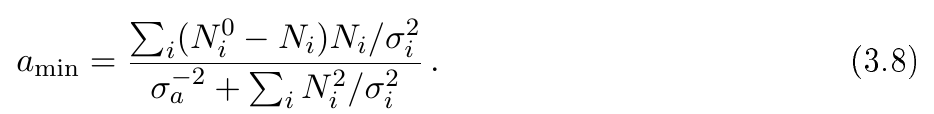

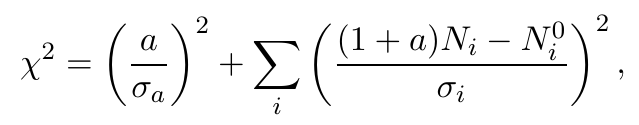

In [8]:
def χ2(N,N0,σ,σa=0):
    if σa==0:
        a=0
        χ2a=0
    else:
        a=np.sum( (N0-N)*N/σ**2 ) /(1/σa**2+ np.sum(N**2/σ**2))
        χ2a=(a/σa)**2
    return χ2a+np.sum((((1+a)*N-N0)/σ)**2)


In [9]:
npa=np.array;
def computeNlist(Φ, model):
    return np.array([diff_rate(Φ,lambda Eν,T: dσdT(Eν,T,model=model),
                               prefactor=scale_factor * Ne_POT ,
                               Tbin=Tbin,discrete_n=discrete_n)  
                     for Tbin in bins])

def init_χ2(set_discrete_n=0,set_flux_σa=[0.02,0.02],set_scale_factor=1,set_χ_cut=2.71,single_bin=False):
    global discrete_n, N0SM, N0SMbar, σa_ν_mode, σa_̄ν_mode,bins,scale_factor,χ2_cut
    
    σa_ν_mode,σa_̄ν_mode=set_flux_σa
    discrete_n=set_discrete_n
    scale_factor=set_scale_factor
    χ2_cut=set_χ_cut # 2.71-> 90% C.L.
    
    if single_bin:
        bins=[[0,100]]
    else:
        binleft=np.linspace(0,8,6)
        binright=np.concatenate([binleft[1:],[100]])
        bins=np.transpose([binleft,binright])
        
    if single_bin and set_discrete_n>=1:
        print("warning: xxxxxxxxx")

    N0SM= computeNlist(Φ_νμ, model={"name":"SM","σ":σ_νμ_SM}) 
    N0SMbar=computeNlist(Φ_̄νμ, model={"name":"SM","σ":σ_̄νμ_SM}) 

init_χ2()

def χ2_model(model):
    model["σ"]=model["σ_νμ"]
    N=   computeNlist(Φ_νμ, model) 
    model["σ"]=model["σ_̄νμ"]
    Nbar=computeNlist(Φ_̄νμ, model)
    return χ2(N,N0SM,σ=np.sqrt(N),σa=σa_ν_mode)+χ2(Nbar,N0SMbar,σ=np.sqrt(Nbar),σa=σa_̄ν_mode)


In [10]:
init_χ2()

g=1e-3;
model={"name":"Zprime","σ":None,"σ_νμ":σ_νμ_Zprime,"σ_̄νμ":σ_̄νμ_Zprime,"gL":g,"gR":g,"gnu":g,"mz":2.0*GeV}
_t=time.time()
print(χ2_model(model)  )
time.time()-_t

0.2402111459161825


3.6162405014038086

In [11]:
init_χ2(5)

g=1e-3;
model={"name":"Zprime","σ":None,"σ_νμ":σ_νμ_Zprime,"σ_̄νμ":σ_̄νμ_Zprime,"gL":g,"gR":g,"gnu":g,"mz":2.0*GeV}
_t=time.time()
print(χ2_model(model)  )
time.time()-_t

0.24069121221479012


1.1809957027435303

In [15]:
init_χ2(set_discrete_n=3,set_scale_factor= 5 * 67.2  )  # 5 yr per mode, each year 1.1e21POT, 67.2 ton

def χ2_g(g,mz,r_eL=1,r_eR=1,r_ν=1):
    model={"name":"Zprime","σ":None,"σ_νμ":σ_νμ_Zprime,"σ_̄νμ":σ_̄νμ_Zprime,
           "gL":g*r_eL,"gR":g*r_eR,"gnu":g*r_ν,"mz":mz}
    return χ2_model(model)

_t=time.time()
mz_list=np.geomspace(1e-3*GeV, 1e3*GeV,3)
sol_list=[0]*len(mz_list)
for i,mz in enumerate(mz_list):
    print ("\r working on mz=", mz,end="###")
    sol_list[i]=so.root_scalar(lambda lgg:χ2_g(10**lgg,mz)-χ2_cut,bracket=[-6,0],rtol=1e-2)
print("\n", [[mz,sol_list[i].root] for i,mz  in enumerate(mz_list)] )
print("time:", time.time()-_t)

 working on mz= 1000.0###
 [[0.001, -4.892110759123949], [1.0, -3.4407147192197325], [1000.0, -0.44832772407158766]]
time: 29.334489345550537


In [16]:
mz_list_optimized=np.concatenate([
    np.geomspace(0.001*GeV, 0.005*GeV,3,endpoint=False),
    np.geomspace(0.005*GeV, 0.2*GeV,20,endpoint=False),
    np.geomspace(0.2*GeV, 1e3*GeV,3)])

In [17]:
sw2=0.23;
xy=(sw2-5/6, sw2)
print(xy)
degree=1/180*Pi
β_vR=159 *degree
β_vR, np.degrees(np.arctan(xy[1]/xy[0])+Pi)


(-0.6033333333333334, 0.23)


(2.775073510670984, 159.1323795945808)

In [401]:
init_χ2(set_discrete_n=3,set_scale_factor= 5 * 67.2  )  # 5 yr per mode, each year 1.1e21POT, 67.2 ton

mz_list=mz_list_optimized

_t=time.time()
# [0,45,90,159,180*]
for β_in_degree in [0,45,90,159,180]:
    β=β_in_degree*degree
    r_eL,r_eR=Cos(β),Sin(β)
    sol_list=[0]*len(mz_list)
    for i,mz in enumerate(mz_list):
        print ("\r working on β=", β_in_degree, ",mz=", mz,end="###")
        sol_list[i]=so.root_scalar(
            lambda lgg:χ2_g(10**lgg,mz,r_eL,r_eR)-χ2_cut,bracket=[-6,0],rtol=1e-3)

    result=np.array([[mz,10**sol_list[i].root] for i,mz  in enumerate(mz_list)])
    np.savetxt("data/DUNE-nu-e-beta"+str(β_in_degree)+".dat",result)
print("time:", time.time()-_t)

 working on β= 180 ,mz= 1000.0###623730951######time: 1411.2751681804657


In [18]:
init_χ2(set_discrete_n=3,set_scale_factor= 5 * 67.2)  # 5 yr per mode, each year 1.1e21POT, 67.2 ton

lgg_list=[]
β_list=np.linspace(0,2*Pi,100)#[-2,-1,-0.38,0,0.5,1,2]
for β in β_list:
    r_eL,r_eR=Cos(β),Sin(β)
    mz=0.001*GeV
    sol=so.root_scalar(
        lambda lgg:χ2_g(10**lgg,mz,r_eL,r_eR)-χ2_cut,bracket=[-6,0],rtol=1e-3)
    print ("\r", β/degree, end="#######")
    lgg_list.append(sol.root)

 360.0#######36364########

In [366]:
np.savetxt("data/beta_lgg.dat",np.transpose([β_list,lgg_list]))

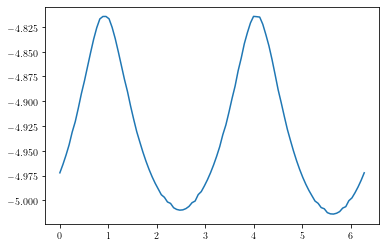

In [20]:
plt.plot(β_list,lgg_list)

In [65]:
init_χ2(set_discrete_n=3,set_scale_factor= 5 * 67.2)  # 5 yr per mode, each year 1.1e21POT, 67.2 ton

lgg_list=[]
β_list=np.linspace(0,2*Pi,100)
for β in β_list:
    r_eL,r_eR=Cos(β),Sin(β)
    
    sols=[so.root_scalar(
        lambda lgg:χ2_g(10**lgg,mz,r_eL,r_eR)-χ2_cut,bracket=[-6,0],rtol=1e-3) 
          for mz in [0.001*GeV,0.03*GeV,1*GeV]]
    print ("\r", β/degree, end="#######")
    lgg_list.append([sol.root for sol in sols])
    
output=np.array([np.concatenate([(β,),lgg_list[i]]) for i,β in enumerate(β_list)])    


 360.0#######36364########

In [66]:
np.savetxt("data/beta_lgg_m.dat",output)

In [409]:
init_χ2(set_discrete_n=3,set_scale_factor= 5 * 67.2)


def computeN(β=45*degree, g=2e-5,r_ν=1, mz=1e-3*GeV):
    r_eL,r_eR=Cos(β),Sin(β)
    model= {"name":"Zprime","σ":None,"σ_νμ":σ_νμ_Zprime,"σ_̄νμ":σ_̄νμ_Zprime,
               "gL":g*r_eL,"gR":g*r_eR,"gnu":g*r_ν,"mz":mz}
    model["σ"]=model["σ_νμ"]
    N=   computeNlist(Φ_νμ, model) 
    model["σ"]=model["σ_̄νμ"]
    Nbar=computeNlist(Φ_̄νμ, model)
    return N, Nbar

In [410]:
# N, Nbar=computeN(β=159*degree, g=3e-3,r_ν=1, mz=1e-1*GeV)
# N2, Nbar2=computeN(β=45*degree, g=3e-3,r_ν=1, mz=1e-1*GeV)
# bin_middle=np.mean(bins,axis=1)
# np.save("data/bin_illustrate.npy", {"bins":bins,"N0SM":N0SM,"N0SMbar":N0SMbar, 
#                                     "N":N, "Nbar":Nbar,"N2":N2,"Nbar2":Nbar2})
# np.savez("data/bin_illustrate.npz",bins,N0SM,N0SMbar,N,Nbar,N2,Nbar2)

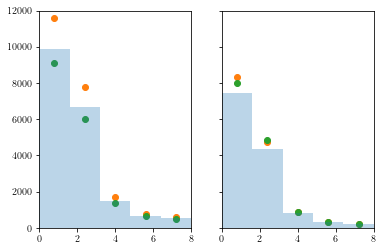

In [412]:
fig, axs=plt.subplots(ncols=2,sharey=True)

N, Nbar=computeN(β=159*degree, g=1e-4,r_ν=1, mz=1e-1*GeV)
N2, Nbar2=computeN(β=45*degree, g=1e-4,r_ν=1, mz=1e-1*GeV)
ax=axs[0]
ax.bar(np.mean(bins,axis=1),N0SM/(bins[:,1]-bins[:,0]),width=1.6,alpha=0.3)
ax.scatter(np.mean(bins,axis=1),N/(bins[:,1]-bins[:,0]))
ax.scatter(np.mean(bins,axis=1),N2/(bins[:,1]-bins[:,0]))
ax=axs[1]
ax.bar(np.mean(bins,axis=1),N0SMbar/(bins[:,1]-bins[:,0]),width=1.6,alpha=0.3)
ax.scatter(np.mean(bins,axis=1),Nbar/(bins[:,1]-bins[:,0]))
ax.scatter(np.mean(bins,axis=1),Nbar2/(bins[:,1]-bins[:,0]))

for ax in axs:
    ax.set_xlim(0,8)
    ax.set_ylim(0,12000)
plt.show()

In [413]:
np.savez("data/bin_illustrate.npz",bins,N0SM,N0SMbar,N,Nbar,N2,Nbar2)